# Importing Libraries

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb

# Importing Data

## Tickers

In [3]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [4]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [5]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [6]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))

In [7]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)

In [8]:
inventory_weights=(holding['Weights in %'].apply(lambda x: np.round(x,2))/100).to_dict()
inventory_weights.pop('Total')

1.0

In [9]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [10]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

### Positions

In [11]:
position=pd.read_excel('Positions.xlsx',index_col=0)

In [12]:
positions=Binance.get_positions_history(enddate=datetime.datetime.today()-datetime.timedelta(1),
                                        startdate=datetime.datetime(2024,5,5))
positions=positions.sort_index()
positions.index=pd.to_datetime(positions.index)

2024-05-05 00:00:00
2024-06-04 00:00:00
2024-07-04 00:00:00
LDUMAUSDT not retrieved


In [13]:
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

In [14]:
positions.to_excel('Positions.xlsx')

In [15]:
positions['Total']=positions.sum(axis=1)
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total']).fillna(0)

In [16]:
binance_data=Binance.get_price(positions.columns,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=np.log(1+binance_data.pct_change())

LDUMAUSDT not retrieved
Total not retrieved


In [17]:
historical_ptf=pd.DataFrame()

In [18]:
for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<AxesSubplot:>

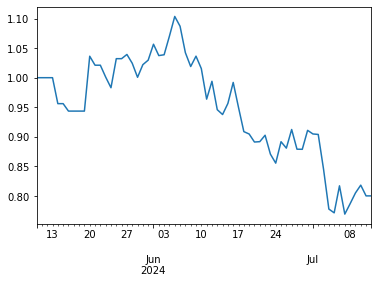

In [19]:
historical_ptf.dropna(axis = 0, how = 'all', inplace = True)
(1+historical_ptf['Historical Portfolio']).cumprod().plot()

### Ex ante data

In [20]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

In [21]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use)
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [22]:
returns_to_use.columns

Index(['AAVEUSDT', 'ADAUSDT', 'ALGOUSDT', 'APTUSDT', 'ARBUSDT', 'ARUSDT',
       'ATOMUSDT', 'AVAXUSDT', 'AXSUSDT', 'BCHUSDT', 'BNBUSDT', 'BONKUSDT',
       'BTCUSDT', 'DOGEUSDT', 'DOTUSDT', 'DYDXUSDT', 'EGLDUSDT', 'ENSUSDT',
       'EOSUSDT', 'ETCUSDT', 'ETHUSDT', 'FDUSDUSDT', 'FETUSDT', 'FILUSDT',
       'FLOKIUSDT', 'FLOWUSDT', 'FTMUSDT', 'GALAUSDT', 'GNOUSDT', 'GRTUSDT',
       'HBARUSDT', 'ICPUSDT', 'IMXUSDT', 'INJUSDT', 'JASMYUSDT', 'LDOUSDT',
       'LINKUSDT', 'LTCUSDT', 'MATICUSDT', 'MKRUSDT', 'NEARUSDT', 'NEOUSDT',
       'NEXOUSDT', 'OMUSDT', 'OPUSDT', 'ORDIUSDT', 'PEPEUSDT', 'QNTUSDT',
       'RNDRUSDT', 'RUNEUSDT', 'SANDUSDT', 'SEIUSDT', 'SHIBUSDT', 'SOLUSDT',
       'STXUSDT', 'SUIUSDT', 'THETAUSDT', 'TIAUSDT', 'TRXUSDT', 'UNIUSDT',
       'USDCUSDT', 'VETUSDT', 'WBETHUSDT', 'WBTCUSDT', 'XLMUSDT', 'XRPUSDT',
       'XTZUSDT'],
      dtype='object')

## Optimal Portfolio

In [23]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[12]-0.30},
                                                           {'type': 'ineq', 'fun': lambda weights: weights[20]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory

,Weights
OMUSDT,0.412052
BTCUSDT,0.300000
ETHUSDT,0.150000
JASMYUSDT,0.076865
PEPEUSDT,0.061083


In [24]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[0]-0.3},
                                                           {'type': 'ineq', 'fun': lambda weights: weights[2]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current

,Weights
JASMYUSDT,0.55
BTCUSDT,0.30
ETHUSDT,0.15


## Real Portfolio vs Optimal

In [25]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights in %']-current_holding_comparison['Weights']
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights in %,Weights,Spread
BTCUSDT,617.575120,3.649681e+01,0.30,36.196808
JASMYUSDT,312.914378,1.849229e+01,0.55,17.942286
ETHUSDT,217.013762,1.282485e+01,0.15,12.674852
SOLUSDT,203.698445,1.203796e+01,0.00,0.000000
BBUSDT,138.058526,8.158838e+00,0.00,0.000000
MKRUSDT,113.713759,6.720137e+00,0.00,0.000000
BNBUSDT,54.190460,3.202491e+00,0.00,0.000000
TRXUSDT,21.433750,1.266669e+00,0.00,0.000000
FETUSDT,13.536413,7.999608e-01,0.00,0.000000
PEPEUSDT,0.000002,1.226853e-07,0.00,0.000000


In [26]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory],axis=1)
historical_comparison['Spread']=historical_comparison['Weights in %']-historical_comparison['Weights']*100
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights in %,Weights,Spread
BTCUSDT,617.575120,3.649681e+01,0.300000,6.496808
JASMYUSDT,312.914378,1.849229e+01,0.076865,10.805786
ETHUSDT,217.013762,1.282485e+01,0.150000,-2.175148
SOLUSDT,203.698445,1.203796e+01,0.000000,0.000000
BBUSDT,138.058526,8.158838e+00,0.000000,0.000000
MKRUSDT,113.713759,6.720137e+00,0.000000,0.000000
BNBUSDT,54.190460,3.202491e+00,0.000000,0.000000
TRXUSDT,21.433750,1.266669e+00,0.000000,0.000000
FETUSDT,13.536413,7.999608e-01,0.000000,0.000000
PEPEUSDT,0.000002,1.226853e-07,0.061083,-6.108300


## Risk Reward Analysis

<AxesSubplot:>

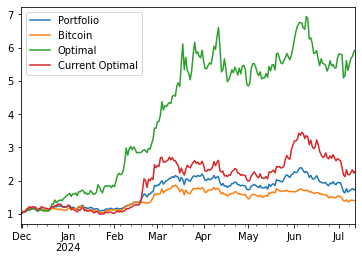

In [27]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf
(1+portfolio_perf).cumprod().plot()

In [28]:
portfolio_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<AxesSubplot:>

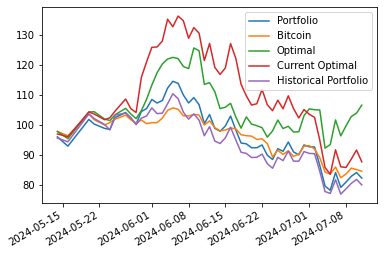

In [29]:
((1+portfolio_perf.loc[positions.index]).cumprod()*100).plot()

In [30]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)

vol

Portfolio    0.719772
dtype: float64

In [31]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio               0.498256
Bitcoin                 0.439072
Optimal                 0.721315
Current Optimal         0.747103
Historical Portfolio    0.492681
dtype: float64

In [32]:
perf_analysis=pd.concat([historical_risk.perf_contrib_pct(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution in %,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,0.014707,0.045333,0.118157,0.033348,0.084809
ETHUSDT,0.006583,0.021979,0.061187,0.010895,0.050292
JASMYUSDT,0.017124,0.023537,0.049211,0.015086,0.034124
OMUSDT,0.942769,0.885797,0.718076,0.624190,0.093886
PEPEUSDT,0.018817,0.023355,0.053369,0.013625,0.039744


In [33]:
perf_analysis=pd.concat([current_risk.perf_contrib_pct(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution in %,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,0.566532,0.350513,0.198327,0.053630,0.144697
JASMYUSDT,-0.465939,0.223715,0.297733,0.127760,0.169973
ETHUSDT,-0.062664,0.143860,0.096621,0.014438,0.082183
SOLUSDT,0.221218,0.114744,0.122663,0.022239,0.100424
BBUSDT,0.482315,0.054839,0.190782,0.065097,0.125686
MKRUSDT,0.126080,0.067126,0.064397,0.007522,0.056875
BNBUSDT,0.060655,0.028340,0.018990,0.000625,0.018365
TRXUSDT,-0.014147,0.011669,0.001598,0.000018,0.001580
FETUSDT,0.085949,0.005195,0.008888,0.000375,0.008513


## Value At Risk

### Historical

In [34]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.05794179160605512, -0.08642697088594307)

In [35]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.058952079300402464, -0.06843434619573954)

### Parametric

In [36]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.07473979315079927, -0.09579575041098087)

In [37]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.05877135707766023, -0.07532863039327217)

### Multivariate

In [38]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.06505893633725525, -0.08507158184830796)

In [39]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.05895905006615389, -0.07385531333470598)

### Copulas

In [40]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06518969785269725, -0.08455321509919334)

In [41]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05932706974154972, -0.073642595232823)

In [42]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06555001716293431, -0.08439416164737915)

In [43]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05990526573328062, -0.07529984960928669)

### Monte Carlo

In [44]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1],opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07720930025404536, -0.09545165857902309)

In [45]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1],current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05990969720320794, -0.07545179937462573)

### VaR Violation

In [46]:
var_data=rolling_var(returns_to_use,opt_weights,window=25,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-09,-0.057026,-0.101454,-0.082127,-0.004365
2024-01-10,-0.057026,-0.101442,-0.081658,0.026237
2024-01-11,-0.057026,-0.100607,-0.081075,0.002405
2024-01-12,-0.057349,-0.106254,-0.088254,-0.055103
2024-01-13,-0.057349,-0.105976,-0.088855,0.012078
...,...,...,...,...
2024-07-08,-0.104601,-0.096926,-0.100240,0.034492
2024-07-09,-0.104601,-0.095374,-0.094821,0.031135
2024-07-10,-0.104601,-0.095495,-0.094451,0.011025
2024-07-11,-0.104601,-0.096094,-0.092421,0.025815


In [47]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.038934,-0.095977,-0.084451,-0.019358
2024-05-29,-0.031662,-0.092187,-0.077939,-0.017579
2024-05-30,-0.031662,-0.081990,-0.070772,0.041142
2024-05-31,-0.026667,-0.077348,-0.063961,0.009638
2024-06-01,-0.026667,-0.077225,-0.063421,0.028599
2024-06-02,-0.026667,-0.078527,-0.067439,-0.010857
2024-06-03,-0.019109,-0.074463,-0.060419,0.007785
2024-06-04,-0.019109,-0.055544,-0.044785,0.038373
2024-06-05,-0.019109,-0.053408,-0.040581,0.020058
2024-06-06,-0.019109,-0.054055,-0.041696,-0.005757


<AxesSubplot:>

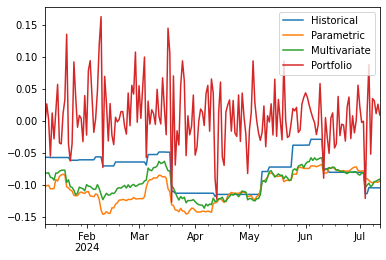

In [48]:
var_data.plot()

<AxesSubplot:>

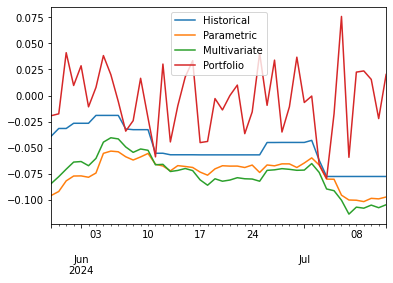

In [49]:
current_var_data.plot()

In [50]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.032258,0.010753,0.016129
Kupiec Stat,1.402191,8.750046,6.033582
P-value,0.236357,0.003096,0.014036


In [51]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.086957,0.0,0.0
Kupiec Stat,1.094089,4.718983,4.718983
P-value,0.295567,0.029831,0.029831


## Principal Component Analysis

In [52]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.75945853, 0.07586926, 0.06407701, 0.05572697, 0.04486823])

In [53]:
eigval,eigvec,portfolio_components=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.60902328, 0.16233131, 0.1009129 , 0.08411117, 0.04362134])